# Simulation Analysis Graphics for Paper - Quartier Nord

by: Clayton Miller

Apr 13, 2016

In [83]:
%matplotlib inline

import esoreader
reload(esoreader)
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
import csv


In [84]:
sns.set_style("whitegrid")

# Get Co-Sim Data

In [85]:
# change this to point to where you checked out the GitHub project
PROJECT_PATH = r"/Users/Clayton/Dropbox/UMEM/Quartier_Nord_EPFL/"

# this is the output of the workflow
ESO_PATH = os.path.join(PROJECT_PATH,'cosimulation','quartier_nord.eso')

# yeah... we need an index for timeseries...
HOURS_IN_YEAR = pd.date_range('2013-01-01', '2013-12-31 T23:00', freq='H')

In [86]:
qn_cosim_eplus = esoreader.read_from_path(ESO_PATH)

In [87]:
heating = qn_cosim_eplus.to_frame('total heating energy', index=HOURS_IN_YEAR, use_key_for_columns=False)#.sum(axis=1)
cooling = qn_cosim_eplus.to_frame('total cooling energy', index=HOURS_IN_YEAR, use_key_for_columns=False)#.sum(axis=1)
df = pd.DataFrame({'Co-Simulation EnergyPlus Heating': heating['Zone Ideal Loads Zone Total Heating Energy'], 
                   'Co-Simulation EnergyPlus Cooling': cooling['Zone Ideal Loads Zone Total Cooling Energy']})
df_cosim_eplus = df*0.000000277777778

In [97]:
df_cosim_eplus

,Co-Simulation EnergyPlus Cooling,Co-Simulation EnergyPlus Heating
2013-01-01 00:00:00,0.000000e+00,50.174413
2013-01-01 01:00:00,0.000000e+00,49.825708
2013-01-01 02:00:00,2.924935e-12,49.657559
2013-01-01 03:00:00,0.000000e+00,49.600771
2013-01-01 04:00:00,7.639756e-13,49.511207
2013-01-01 05:00:00,1.120497e-12,49.401244
2013-01-01 06:00:00,1.797162e-12,48.347422
2013-01-01 07:00:00,2.546585e-13,48.285069
2013-01-01 08:00:00,1.280569e-12,47.993230
2013-01-01 09:00:00,0.000000e+00,45.009395


# Get E+ Solo Data

In [152]:
# this is the output of the workflow
ESO_PATH = os.path.join(PROJECT_PATH, 'nord_only_EP', 'eplusout.eso')

In [153]:
eplus_solo = esoreader.read_from_path(ESO_PATH)
heating = eplus_solo.to_frame('total heating energy', index=HOURS_IN_YEAR, use_key_for_columns=False, frequency="HOURLY")#.sum(axis=1)
cooling = eplus_solo.to_frame('total cooling energy', index=HOURS_IN_YEAR, use_key_for_columns=False, frequency="HOURLY")#.sum(axis=1)
df = pd.DataFrame({'Solo EnergyPlus Heating': heating['Zone Ideal Loads Supply Air Total Heating Energy'], 
                   'Solo EnergyPlus Cooling': cooling['Zone Ideal Loads Supply Air Total Cooling Energy']})
df_solo_eplus = df*0.000000277777778

In [154]:
df_solo_eplus

,Solo EnergyPlus Cooling,Solo EnergyPlus Heating
2013-01-01 00:00:00,0,52.138655
2013-01-01 01:00:00,0,53.807649
2013-01-01 02:00:00,0,55.440217
2013-01-01 03:00:00,0,57.039776
2013-01-01 04:00:00,0,58.283020
2013-01-01 05:00:00,0,59.552173
2013-01-01 06:00:00,0,56.560956
2013-01-01 07:00:00,0,57.642051
2013-01-01 08:00:00,0,57.618172
2013-01-01 09:00:00,0,46.541085


In [157]:
energyplus = pd.merge(df_solo_eplus, df_cosim_eplus, right_index=True, left_index=True, how='outer')

In [158]:
energyplus = energyplus[['Co-Simulation EnergyPlus Heating','Co-Simulation EnergyPlus Cooling','Solo EnergyPlus Heating','Solo EnergyPlus Cooling']]

In [160]:
#energyplus

# Get CitySim Data

In [217]:
def get_citysimdata(path,key):
    varlist = []
    hours_in_year = pd.date_range('2013-01-01', '2013-12-31 T23:00', freq='H')
    with open(path[1], 'r') as infile:
        reader = csv.DictReader(infile, dialect=csv.Sniffer().sniff(infile.read(1000)))
        infile.seek(0)
        for row in reader:
            varlist.append(float(row[key]))
    #colname = key[0]+" "+path[0]
    df = pd.DataFrame({key:pd.Series(varlist,index=hours_in_year)})
    return df


In [290]:
#,,,'3(3):3:Heating(Wh)''5(5):5:Heating(Wh)''4(4):4:Heating(Wh)''1(1):1:Cooling(Wh)'
#,,,'3(3):3:Cooling(Wh)''5(5):5:Cooling(Wh)''4(4):4:Cooling(Wh)''1(1):1:Heating(Wh)'
keys = [['Heating',['5(5):5:Heating(Wh)']],['Cooling',['5(5):5:Cooling(Wh)']]]
paths = [['Co-Simulation CitySim',r'/Users/Clayton/Dropbox/UMEM/Quartier_Nord_EPFL/cosimulation/quartier_nord_TH.out'],['Solo CitySim',r'/Users/Clayton/Dropbox/UMEM/Quartier_Nord_EPFL/nord_only_CitySim/nord_only_CitySim_TH.out']]

city_sim = pd.DataFrame()
for sim_type in paths:
    energydf = pd.DataFrame()
    for energy_type in keys:
        for subsection in energy_type[1]:
            df = get_citysimdata(sim_type, subsection)
            energydf = pd.merge(energydf, df, right_index=True, left_index=True, how='outer')
        energysum = pd.DataFrame({sim_type[0]+" "+energy_type[0]:energydf.sum(axis=1)})
        city_sim = pd.merge(city_sim, energysum, right_index=True, left_index=True, how='outer')
city_sim = np.abs(city_sim/1000) #convert to kWh

In [291]:
#city_sim

# Plot comparisons

In [299]:
def plot_comparison(df, colorpalette, filename, title, colabbrev):
    current_palette = sns.color_palette(colorpalette, 4)
    sns.set_palette(current_palette)


    fig1 = plt.figure(figsize=[15,3])
    fig1.suptitle(title)

    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)

    ax1 = fig1.add_subplot(gs[:,0:70])
    styles1 = ['s-','^-','<-','-H']
    df.resample("W",how='sum').plot(style=styles1, ax=ax1)
    ax1.set_ylabel("Weekly Cooling and Heating [kWh]")

    df_bar_combined = df.resample('A',how='sum')
    df_bar_combined.columns = colabbrev
    ax3 = fig1.add_subplot(gs[:,80:100])
    
    df_bar_combined.T.plot(kind='bar',color=current_palette, legend=False, ax=ax3)
    ax3.set_ylabel("Annual Cooling and Heating [kWh]")

    plt.subplots_adjust(bottom=0.5)

    plt.savefig(filename,bbox_inches='tight')
    plt.show()

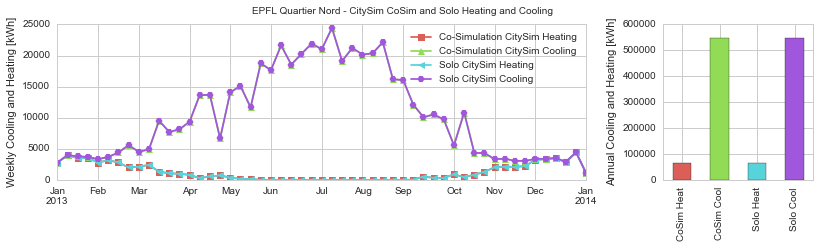

In [300]:
plot_comparison(city_sim, "hls", "QN_CitySim.pdf", "EPFL Quartier Nord - CitySim CoSim and Solo Heating and Cooling",["CoSim Heat","CoSim Cool","Solo Heat","Solo Cool"])

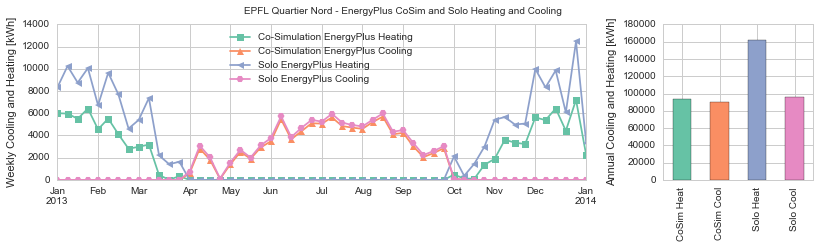

In [301]:
plot_comparison(energyplus, "Set2", "QN_EnergyPlus.pdf", "EPFL Quartier Nord - EnergyPlus CoSim and Solo Heating and Cooling",["CoSim Heat","CoSim Cool","Solo Heat","Solo Cool"])

In [302]:
allheating = pd.merge(energyplus[["Co-Simulation EnergyPlus Heating","Solo EnergyPlus Heating"]], city_sim[["Co-Simulation CitySim Heating","Solo CitySim Heating"]],right_index=True, left_index=True)

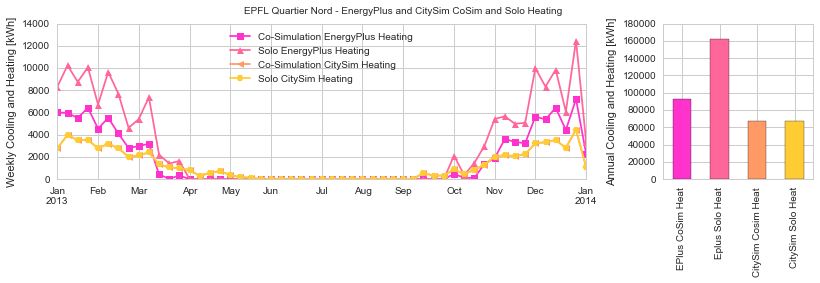

In [304]:
plot_comparison(allheating, "spring", "QN_Heating.pdf", "EPFL Quartier Nord - EnergyPlus and CitySim CoSim and Solo Heating",["EPlus CoSim Heat","Eplus Solo Heat","CitySim Cosim Heat","CitySim Solo Heat"])

In [224]:
allcooling = pd.merge(energyplus[["Co-Simulation EnergyPlus Cooling","Solo EnergyPlus Cooling"]], city_sim[["Co-Simulation CitySim Cooling","Solo CitySim Cooling"]],right_index=True, left_index=True)

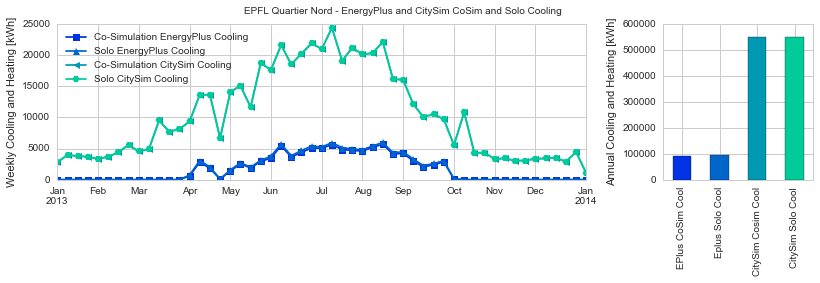

In [306]:
plot_comparison(allcooling, "winter", "QN_Cooling.pdf", "EPFL Quartier Nord - EnergyPlus and CitySim CoSim and Solo Cooling",["EPlus CoSim Cool","Eplus Solo Cool","CitySim Cosim Cool","CitySim Solo Cool"])

# Make the heating and cooling co-sim vs. solo charts

In [227]:
city_sim_annual = city_sim.resample('A',how='sum')

In [229]:
city_sim.columns

Index([u'Co-Simulation CitySim Heating', u'Co-Simulation CitySim Cooling',
       u'Solo CitySim Heating', u'Solo CitySim Cooling'],
      dtype='object')

In [242]:
def pivot_day(df, cols, startdate, enddate):
    df_forpiv = df.truncate(before=startdate, after=enddate).resample('2H', how='mean')
    #df_cooling_forpiv.columns = ["1","2","3","4"]

    df_forpiv['Date'] = df_forpiv.index.map(lambda t: t.date())
    df_forpiv['Time'] = df_forpiv.index.map(lambda t: t.time())

    df_pivot_1 = pd.pivot_table(df_forpiv, values=cols[0], index='Date', columns='Time')
    df_pivot_2 = pd.pivot_table(df_forpiv, values=cols[1], index='Date', columns='Time')
#     df_pivot_3 = pd.pivot_table(df_forpiv, values=cols[2], index='Date', columns='Time')
#     df_pivot_4 = pd.pivot_table(df_forpiv, values=cols[3], index='Date', columns='Time')

    df_pivot_sum = pd.DataFrame()
    df_pivot_sum[cols[0]] = df_pivot_1.mean()#.plot(figsize=(20,8))
    df_pivot_sum[cols[1]] = df_pivot_2.mean()#.plot()
#     df_pivot_sum[cols[2]] = df_pivot_3.mean()#.plot()
#     df_pivot_sum[cols[3]] = df_pivot_4.mean()#.plot()
    
    return df_pivot_sum

In [361]:
def plot_cosim_vs_solo(df, df_pivot, colorpalette, ylabel1, ylabel2, ylabel3, filename, title, colnames):
    current_palette = sns.color_palette(colorpalette, 2)
    sns.set_palette(current_palette)

    fig1 = plt.figure(figsize=[15,3])
    fig1.suptitle(title, fontsize=14)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)

    ax1 = fig1.add_subplot(gs[:,0:32])
    styles1 = ['s-','^-','<-']
    df.columns = colnames
    df_pivot.columns = colnames
    df_pivot.plot(style=styles1, ax=ax1, xticks=arange(0, 86400, 21600))

    ax1.set_ylabel(ylabel1)
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'));

    ax2 = fig1.add_subplot(gs[:,42:72])
    styles1 = ['s-','^-','<-']
    
    df.resample('M',how='sum').plot(style=styles1, ax=ax2)#.legend(loc='center left', bbox_to_anchor=(0, -0.5),), title="Monthly Total"
    ax2.set_ylabel(ylabel2)
    # df_netradiation.resample('M',how='sum').plot(style=styles1, ax=ax2, title="Monthly Total All Surfaces")#.legend(loc='center left', bbox_to_anchor=(0, -0.5),)
    # ax2.set_ylabel("Monthly Net Thermal Radiation [J]")
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'));

    df_bar = df
    #df_bar.columns = ["CoSim","Solo"] #,"3","4"
    ax3 = fig1.add_subplot(gs[:,82:100])
    df_bar.resample('A',how='sum').T.plot(kind='bar',color=current_palette, legend=False, ax=ax3) #, title="Annual Total"
    ax3.set_ylabel(ylabel3)
#     ax3.annotate(Exp2Annontate, xy=(0, 8000), xytext=(0.7, df_annual["2_C_NS"][0]+400))
#     ax3.annotate(Exp3Annontate, xy=(0, 8000), xytext=(1.7, df_annual["3_S_WS"][0]+400))
#     ax3.annotate(Exp4Annontate, xy=(0, 8000), xytext=(2.7, df_annual["4_C_WS"][0]+400))

#     ax3.annotate(Exp2Annontate2, xy=(0, 8000), xytext=(0.8, df_annual["2_C_NS"][0]+3500))
#     ax3.annotate(Exp3Annontate2, xy=(0, 8000), xytext=(1.8, df_annual["3_S_WS"][0]+3500))
#     ax3.annotate(Exp4Annontate2, xy=(0, 8000), xytext=(2.8, df_annual["4_C_WS"][0]+3500))

    # ax2.set_xticklabels(colnames, rotation=80)
    plt.subplots_adjust(bottom=0.5)
    # plt.tight_layout()
    plt.savefig(filename,bbox_inches='tight')
    plt.show()

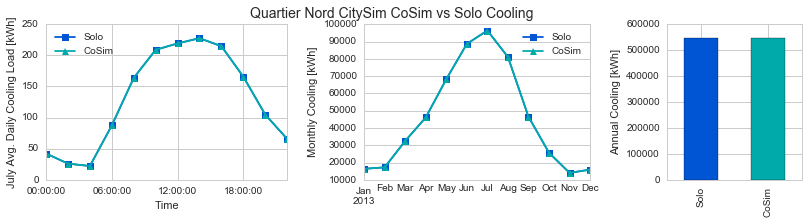

In [362]:
city_sim_cooling = city_sim[['Co-Simulation CitySim Cooling','Solo CitySim Cooling']]
city_sim_cooling_pivot = pivot_day(city_sim_cooling, list(city_sim_cooling.columns), '2013-07-01','2013-07-31')
plot_cosim_vs_solo(city_sim_cooling, city_sim_cooling_pivot, "winter", "July Avg. Daily Cooling Load [kWh]", "Monthly Cooling [kWh]", "Annual Cooling [kWh]", "QN_CitySim_Cooling.pdf","Quartier Nord CitySim CoSim vs Solo Cooling",["Solo","CoSim"])

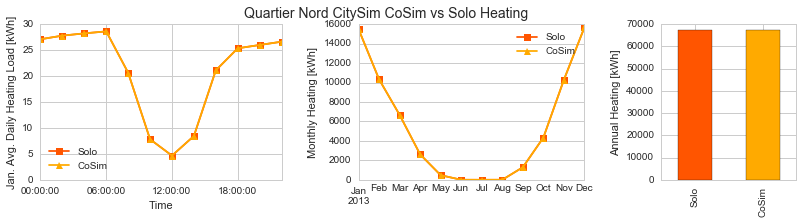

In [363]:
city_sim_heating = city_sim[['Solo CitySim Heating','Co-Simulation CitySim Heating']]
city_sim_heating_pivot = pivot_day(city_sim_heating, list(city_sim_heating.columns), '2013-01-01','2013-01-31')
plot_cosim_vs_solo(city_sim_heating, city_sim_heating_pivot, "autumn", "Jan. Avg. Daily Heating Load [kWh]", "Monthly Heating [kWh]", "Annual Heating [kWh]", "QN_CitySim_Heating.pdf","Quartier Nord CitySim CoSim vs Solo Heating",["Solo","CoSim"])

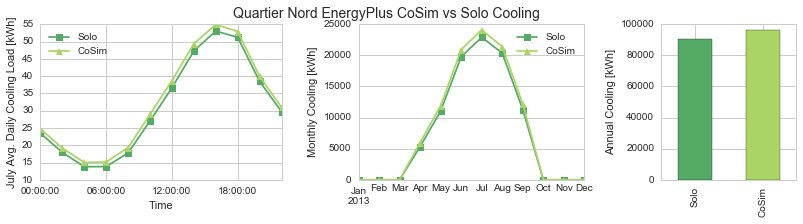

In [364]:
energyplus_cooling = energyplus[['Co-Simulation EnergyPlus Cooling','Solo EnergyPlus Cooling']]
energyplus_cooling_pivot = pivot_day(energyplus_cooling, list(energyplus_cooling.columns), '2013-07-01','2013-07-31')
plot_cosim_vs_solo(energyplus_cooling, energyplus_cooling_pivot, "summer", "July Avg. Daily Cooling Load [kWh]", "Monthly Cooling [kWh]", "Annual Cooling [kWh]", "QN_EnergyPlus_Cooling.pdf","Quartier Nord EnergyPlus CoSim vs Solo Cooling",["Solo","CoSim"])

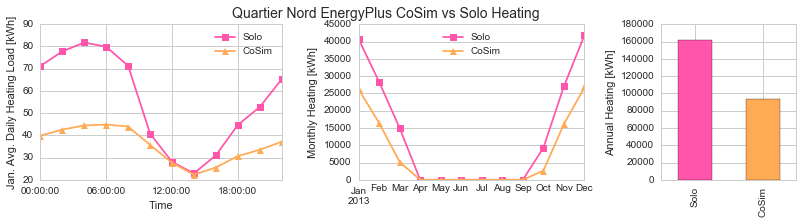

In [365]:
energyplus_heating = energyplus[['Solo EnergyPlus Heating','Co-Simulation EnergyPlus Heating']]
energyplus_heating_pivot = pivot_day(energyplus_heating, list(energyplus_heating.columns), '2013-01-01','2013-01-31')
plot_cosim_vs_solo(energyplus_heating, energyplus_heating_pivot, "spring", "Jan. Avg. Daily Heating Load [kWh]", "Monthly Heating [kWh]", "Annual Heating [kWh]", "QN_EnergyPlus_Heating.pdf","Quartier Nord EnergyPlus CoSim vs Solo Heating",["Solo","CoSim"])